# 0. Imports

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

import datetime

import matplotlib.pyplot as plt

import torch
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

from tqdm import tqdm

from pyts.image import GramianAngularField

torch.manual_seed(41)

In [2]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        torch.nn.init.xavier_uniform_(m.weight.data)

# 1. Data

Processed dataset from [Part 1](https://github.com/johnwslee/fine_dust_analysis) will be used as raw data for study.

In [3]:
df = pd.read_csv(
    "../data/seoul_fine_dust_weather_2008_2021_for_ml.csv",
    index_col=0,
    parse_dates=True,
).reset_index()

In [4]:
df.head()

,date,temp(°C),precipitation(mm),wind_speed(m/s),wind_direction,humidity(%),local_P(hPa),cloud_cover,lowest_ceiling(100m),month,PM10_Counts,PM25_Counts,log_PM10_Counts,log_PM25_Counts
0,2008-01-01 10:00:00,-7.6,0.0,4.6,340.0,47.0,1010.7,2.0,12.0,1,30.0,11.0,3.433987,2.484907
1,2008-01-01 11:00:00,-6.9,0.0,4.1,290.0,42.0,1010.7,2.0,12.0,1,29.0,13.0,3.401197,2.639057
2,2008-01-01 12:00:00,-5.8,0.0,4.1,290.0,42.0,1010.7,2.0,12.0,1,29.0,12.0,3.401197,2.564949
3,2008-01-01 13:00:00,-5.0,0.0,4.1,290.0,36.0,1009.9,0.0,10.0,1,28.0,12.0,3.367296,2.564949
4,2008-01-01 14:00:00,-4.4,0.0,4.1,290.0,36.0,1009.9,0.0,10.0,1,27.0,13.0,3.332205,2.639057


The dataset above will be transformed so that it can be used for multi-scale timeseries classification. In order to do so, `wind_direction`, `humidity(%)`, `lowest_ceiling(100m)`, `temp(°C)`, `wind_speed(m/s)`, `local_P(hPa)`, `precipitation(mm)`, and `PM10_Counts` will be used as features, whereas the binary target, `Air_is_bad?` will be generated based on `PM10_Counts` of the next day.

In [5]:
new_columns = [
    "date",
    "wind_direction",
    "humidity(%)",
    "lowest_ceiling(100m)",
    "temp(°C)",
    "wind_speed(m/s)",
    "local_P(hPa)",
    "precipitation(mm)",
    "PM10_Counts",
]

In [6]:
df = df[new_columns]

In [7]:
df

,date,wind_direction,humidity(%),lowest_ceiling(100m),temp(°C),wind_speed(m/s),local_P(hPa),precipitation(mm),PM10_Counts
0,2008-01-01 10:00:00,340.0,47.0,12.0,-7.6,4.6,1010.7,0.0,30.0
1,2008-01-01 11:00:00,290.0,42.0,12.0,-6.9,4.1,1010.7,0.0,29.0
2,2008-01-01 12:00:00,290.0,42.0,12.0,-5.8,4.1,1010.7,0.0,29.0
3,2008-01-01 13:00:00,290.0,36.0,10.0,-5.0,4.1,1009.9,0.0,28.0
4,2008-01-01 14:00:00,290.0,36.0,10.0,-4.4,4.1,1009.9,0.0,27.0
...,...,...,...,...,...,...,...,...,...
122728,2021-12-31 05:00:00,270.0,39.0,10.0,-7.7,3.5,1018.5,0.0,25.0
122729,2021-12-31 06:00:00,290.0,40.0,10.0,-8.0,3.2,1019.2,0.0,23.0
122730,2021-12-31 07:00:00,270.0,42.0,10.0,-8.6,2.7,1019.9,0.0,22.0
122731,2021-12-31 08:00:00,270.0,42.0,10.0,-8.8,2.9,1020.8,0.0,22.0


Since the time starts from 10 for 2008-01-01, the dataset should start from 2008-01-02 so that all features have equal length of data per day. The same goes for 2021-12-31. So Feature will range from 2008-01-02 to 2021-12-29, while it will be from 2008-01-03 to 2021-12-30 for target.

## 1.1. Target Preparation

In [8]:
df.loc[df["PM10_Counts"] > 45].shape[0]

46562

In [9]:
df.shape[0]

122733

In [10]:
pm10_count = df[["date", "PM10_Counts"]]

In [11]:
pm10_count

,date,PM10_Counts
0,2008-01-01 10:00:00,30.0
1,2008-01-01 11:00:00,29.0
2,2008-01-01 12:00:00,29.0
3,2008-01-01 13:00:00,28.0
4,2008-01-01 14:00:00,27.0
...,...,...
122728,2021-12-31 05:00:00,25.0
122729,2021-12-31 06:00:00,23.0
122730,2021-12-31 07:00:00,22.0
122731,2021-12-31 08:00:00,22.0


In [12]:
pm10_count["date_new"] = pm10_count["date"].dt.date

In [13]:
target = pm10_count.groupby("date_new").mean().reset_index()

In [14]:
target["date_new"] = pd.to_datetime(target["date_new"])

In [15]:
target["Air_is_bad?"] = np.where(target["PM10_Counts"] >= 45, 1, 0)

In [16]:
target = target[["date_new", "Air_is_bad?"]]

In [17]:
target = target.loc[
    (target["date_new"].dt.date >= datetime.date(2008, 1, 3)) &
    (target["date_new"].dt.date <= datetime.date(2021, 12, 30))
].reset_index(drop=True)

In [18]:
target

,date_new,Air_is_bad?
0,2008-01-03,1
1,2008-01-04,1
2,2008-01-05,1
3,2008-01-06,1
4,2008-01-07,1
...,...,...
5106,2021-12-26,0
5107,2021-12-27,0
5108,2021-12-28,1
5109,2021-12-29,1


## 1.2. Train/Test Split

In [19]:
train_df = df.loc[df["date"].dt.date < datetime.date(2016, 1, 1)]
test_df = df.loc[df["date"].dt.date >= datetime.date(2016, 1, 1)]

## 1.3. Feature Preparation

In [20]:
feature_names = list(df.columns[1:])

In [21]:
scaler = StandardScaler()

In [22]:
train_df[feature_names] = scaler.fit_transform(train_df[feature_names])

In [23]:
test_df[feature_names] = scaler.transform(test_df[feature_names])

In [24]:
# Concatenate train/test df just for convenience of dataset preparation

features = pd.concat([train_df, test_df], axis=0)

In [25]:
features["date_new"] = features["date"].dt.date

In [26]:
features

,date,wind_direction,humidity(%),lowest_ceiling(100m),temp(°C),wind_speed(m/s),local_P(hPa),precipitation(mm),PM10_Counts,date_new
0,2008-01-01 10:00:00,1.379492,-0.665907,-0.223685,-1.837310,1.384209,0.614341,-0.119068,-0.484375,2008-01-01
1,2008-01-01 11:00:00,0.924452,-0.916402,-0.223685,-1.774089,1.032243,0.614341,-0.119068,-0.511732,2008-01-01
2,2008-01-01 12:00:00,0.924452,-0.916402,-0.223685,-1.674743,1.032243,0.614341,-0.119068,-0.511732,2008-01-01
3,2008-01-01 13:00:00,0.924452,-1.216997,-0.438062,-1.602491,1.032243,0.513459,-0.119068,-0.539090,2008-01-01
4,2008-01-01 14:00:00,0.924452,-1.216997,-0.438062,-1.548302,1.032243,0.513459,-0.119068,-0.566447,2008-01-01
...,...,...,...,...,...,...,...,...,...,...
122728,2021-12-31 05:00:00,0.742436,-1.066699,-0.438062,-1.846341,0.609884,1.597937,-0.119068,-0.621163,2021-12-31
122729,2021-12-31 06:00:00,0.924452,-1.016600,-0.438062,-1.873436,0.398704,1.686208,-0.119068,-0.675878,2021-12-31
122730,2021-12-31 07:00:00,0.742436,-0.916402,-0.438062,-1.927625,0.046738,1.774479,-0.119068,-0.703235,2021-12-31
122731,2021-12-31 08:00:00,0.742436,-0.916402,-0.438062,-1.945688,0.187525,1.887971,-0.119068,-0.703235,2021-12-31


In [27]:
features = (
    features.groupby("date_new")
    .agg(list)[
        [
            "wind_direction",
            "humidity(%)",
            "lowest_ceiling(100m)",
            "temp(°C)",
            "wind_speed(m/s)",
            "local_P(hPa)",
            "precipitation(mm)",
            "PM10_Counts",
        ]
    ]
    .reset_index()
)

In [28]:
features["date_new"] = pd.to_datetime(features["date_new"])

In [29]:
features.head()

,date_new,wind_direction,humidity(%),lowest_ceiling(100m),temp(°C),wind_speed(m/s),local_P(hPa),precipitation(mm),PM10_Counts
0,2008-01-01,"[1.3794924231559433, 0.924452475006894, 0.9244...","[-0.665906724059201, -0.9164020855164998, -0.9...","[-0.22368526895253332, -0.22368526895253332, -...","[-1.8373098159974528, -1.7740892697507045, -1....","[1.3842093884999658, 1.0322432575055385, 1.032...","[0.6143406738734757, 0.6143406738734757, 0.614...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.48437493777652446, -0.5117324550480038, -0..."
1,2008-01-02,"[0.924452475006894, 1.1974764438963235, 1.1974...","[-0.16491600114460359, -0.665906724059201, -0....","[-0.5452500390488106, -0.5452500390488106, -0....","[-1.7379632433239907, -1.62958516404385, -1.53...","[-0.5164077188699413, 0.11713131692002768, 0.1...","[0.9043753409882764, 1.1817998051850536, 1.181...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.32022983414764833, -0.15608473051877228, -..."
2,2008-01-03,"[-1.7147792242575914, -1.2597392761085422, -1....","[-0.06471785656168408, -0.11481692885314383, -...","[-0.22368526895253332, -0.8668148091450879, -0...","[-1.3496084592368196, -1.1870413403166087, -1....","[-1.8538790166487649, -0.6571941712677122, -0....","[1.1187487905948783, 0.7782733118079257, 0.778...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.15608473051877228, 0.19956299401045927, 0...."
3,2008-01-04,"[0.924452475006894, -1.5327632449979716, 1.379...","[0.035480288021235415, -0.01461878427022433, -...","[-0.8668148091450879, -0.8668148091450879, -0....","[-1.2231673667433223, -1.2592933931700356, -1....","[0.046738090721142475, -0.5164077188699413, -1...","[1.1817998051850536, 1.3331222402014657, 1.333...","[-0.11906781300263639, -0.11906781300263639, -...","[0.500495683996732, 1.1570760985122364, 1.4032..."
4,2008-01-05,"[0.7424364957472743, -1.5327632449979716, -1.2...","[-0.6158076517677413, 0.035480288021235415, -0...","[-0.5452500390488106, -0.5452500390488106, -0....","[-1.1328523006765383, -1.12382079406986, -0.97...","[-0.9387670760632539, -0.6571941712677122, -1....","[0.9548161526604138, 0.9043753409882764, 0.904...","[-0.11906781300263639, -0.11906781300263639, -...","[0.500495683996732, 0.9929309948833603, 1.4032..."


In [30]:
features = features.loc[
    (features["date_new"].dt.date >= datetime.date(2008, 1, 2))
    & (features["date_new"].dt.date <= datetime.date(2021, 12, 29))
].reset_index(drop=True)

In [31]:
features

,date_new,wind_direction,humidity(%),lowest_ceiling(100m),temp(°C),wind_speed(m/s),local_P(hPa),precipitation(mm),PM10_Counts
0,2008-01-02,"[0.924452475006894, 1.1974764438963235, 1.1974...","[-0.16491600114460359, -0.665906724059201, -0....","[-0.5452500390488106, -0.5452500390488106, -0....","[-1.7379632433239907, -1.62958516404385, -1.53...","[-0.5164077188699413, 0.11713131692002768, 0.1...","[0.9043753409882764, 1.1817998051850536, 1.181...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.32022983414764833, -0.15608473051877228, -..."
1,2008-01-03,"[-1.7147792242575914, -1.2597392761085422, -1....","[-0.06471785656168408, -0.11481692885314383, -...","[-0.22368526895253332, -0.8668148091450879, -0...","[-1.3496084592368196, -1.1870413403166087, -1....","[-1.8538790166487649, -0.6571941712677122, -0....","[1.1187487905948783, 0.7782733118079257, 0.778...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.15608473051877228, 0.19956299401045927, 0...."
2,2008-01-04,"[0.924452475006894, -1.5327632449979716, 1.379...","[0.035480288021235415, -0.01461878427022433, -...","[-0.8668148091450879, -0.8668148091450879, -0....","[-1.2231673667433223, -1.2592933931700356, -1....","[0.046738090721142475, -0.5164077188699413, -1...","[1.1817998051850536, 1.3331222402014657, 1.333...","[-0.11906781300263639, -0.11906781300263639, -...","[0.500495683996732, 1.1570760985122364, 1.4032..."
3,2008-01-05,"[0.7424364957472743, -1.5327632449979716, -1.2...","[-0.6158076517677413, 0.035480288021235415, -0...","[-0.5452500390488106, -0.5452500390488106, -0....","[-1.1328523006765383, -1.12382079406986, -0.97...","[-0.9387670760632539, -0.6571941712677122, -1....","[0.9548161526604138, 0.9043753409882764, 0.904...","[-0.11906781300263639, -0.11906781300263639, -...","[0.500495683996732, 0.9929309948833603, 1.4032..."
4,2008-01-06,"[-1.5327632449979716, -0.8957073175893028, -0....","[0.8871645169760511, 0.5364710109358329, 0.436...","[-0.4380617823500515, -0.974003065843847, -0.9...","[-1.0515687412164327, -0.8619071024761865, -0....","[-1.0091603022621394, -1.0795535284610247, -1....","[0.9548161526604138, 0.9043753409882764, 0.904...","[-0.11906781300263639, -0.11906781300263639, -...","[0.36370809763933537, 1.512723823041468, 1.649..."
...,...,...,...,...,...,...,...,...,...
5106,2021-12-25,"[0.924452475006894, 0.924452475006894, 0.74243...","[-0.4655104348933621, -0.9164020855164998, -1....","[-0.11649701225377423, -0.11649701225377423, -...","[-1.8102152961774178, -2.252759119904659, -2.1...","[1.5953890670966224, 0.609883900312226, 0.6802...","[1.2700712256112905, 2.039293603611432, 2.0392...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.21079976506173095, -0.7853076277627973, -0..."
5107,2021-12-26,"[0.7424364957472743, 0.7424364957472743, 0.924...","[-0.7160057963506608, -0.8162039409335803, -0....","[-0.11649701225377423, -0.11649701225377423, -...","[-2.451452265251584, -2.388231719004835, -2.29...","[-0.3756212664721703, 0.6802771265111115, 0.18...","[2.3671588794803324, 2.518481314496759, 2.4680...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.8126651450342767, -0.9494527313916734, -0...."
5108,2021-12-27,"[1.1974764438963235, -1.2597392761085422, -0.8...","[-0.36531229031044254, -0.31521321801898283, -...","[-0.11649701225377423, -0.11649701225377423, -...","[-2.2437276132979806, -1.9185933754575586, -1....","[-0.23483481407439957, -0.5164077188699413, -0...","[2.1275650240376835, 1.963632386103219, 1.9258...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.8673801795772353, -0.48437493777652446, -0..."
5109,2021-12-28,"[-1.5327632449979716, -1.2597392761085422, -1....","[1.1376598784333498, 1.0374617338504304, 0.636...","[-0.3308735256512924, -0.3308735256512924, -0....","[-1.7199002301106339, -1.6657111904705635, -1....","[-0.30522804027328476, -0.3756212664721703, -0...","[1.7114283277425177, 1.7240385306605557, 1.686...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.18344224

## 1.5. Dataset Preparation

In [32]:
data = pd.concat([features, target["Air_is_bad?"]], axis=1)

In [33]:
data

,date_new,wind_direction,humidity(%),lowest_ceiling(100m),temp(°C),wind_speed(m/s),local_P(hPa),precipitation(mm),PM10_Counts,Air_is_bad?
0,2008-01-02,"[0.924452475006894, 1.1974764438963235, 1.1974...","[-0.16491600114460359, -0.665906724059201, -0....","[-0.5452500390488106, -0.5452500390488106, -0....","[-1.7379632433239907, -1.62958516404385, -1.53...","[-0.5164077188699413, 0.11713131692002768, 0.1...","[0.9043753409882764, 1.1817998051850536, 1.181...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.32022983414764833, -0.15608473051877228, -...",1
1,2008-01-03,"[-1.7147792242575914, -1.2597392761085422, -1....","[-0.06471785656168408, -0.11481692885314383, -...","[-0.22368526895253332, -0.8668148091450879, -0...","[-1.3496084592368196, -1.1870413403166087, -1....","[-1.8538790166487649, -0.6571941712677122, -0....","[1.1187487905948783, 0.7782733118079257, 0.778...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.15608473051877228, 0.19956299401045927, 0....",1
2,2008-01-04,"[0.924452475006894, -1.5327632449979716, 1.379...","[0.035480288021235415, -0.01461878427022433, -...","[-0.8668148091450879, -0.8668148091450879, -0....","[-1.2231673667433223, -1.2592933931700356, -1....","[0.046738090721142475, -0.5164077188699413, -1...","[1.1817998051850536, 1.3331222402014657, 1.333...","[-0.11906781300263639, -0.11906781300263639, -...","[0.500495683996732, 1.1570760985122364, 1.4032...",1
3,2008-01-05,"[0.7424364957472743, -1.5327632449979716, -1.2...","[-0.6158076517677413, 0.035480288021235415, -0...","[-0.5452500390488106, -0.5452500390488106, -0....","[-1.1328523006765383, -1.12382079406986, -0.97...","[-0.9387670760632539, -0.6571941712677122, -1....","[0.9548161526604138, 0.9043753409882764, 0.904...","[-0.11906781300263639, -0.11906781300263639, -...","[0.500495683996732, 0.9929309948833603, 1.4032...",1
4,2008-01-06,"[-1.5327632449979716, -0.8957073175893028, -0....","[0.8871645169760511, 0.5364710109358329, 0.436...","[-0.4380617823500515, -0.974003065843847, -0.9...","[-1.0515687412164327, -0.8619071024761865, -0....","[-1.0091603022621394, -1.0795535284610247, -1....","[0.9548161526604138, 0.9043753409882764, 0.904...","[-0.11906781300263639, -0.11906781300263639, -...","[0.36370809763933537, 1.512723823041468, 1.649...",1
...,...,...,...,...,...,...,...,...,...,...
5106,2021-12-25,"[0.924452475006894, 0.924452475006894, 0.74243...","[-0.4655104348933621, -0.9164020855164998, -1....","[-0.11649701225377423, -0.11649701225377423, -...","[-1.8102152961774178, -2.252759119904659, -2.1...","[1.5953890670966224, 0.609883900312226, 0.6802...","[1.2700712256112905, 2.039293603611432, 2.0392...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.21079976506173095, -0.7853076277627973, -0...",0
5107,2021-12-26,"[0.7424364957472743, 0.7424364957472743, 0.924...","[-0.7160057963506608, -0.8162039409335803, -0....","[-0.11649701225377423, -0.11649701225377423, -...","[-2.451452265251584, -2.388231719004835, -2.29...","[-0.3756212664721703, 0.6802771265111115, 0.18...","[2.3671588794803324, 2.518481314496759, 2.4680...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.8126651450342767, -0.9494527313916734, -0....",0
5108,2021-12-27,"[1.1974764438963235, -1.2597392761085422, -0.8...","[-0.36531229031044254, -0.31521321801898283, -...","[-0.11649701225377423, -0.11649701225377423, -...","[-2.2437276132979806, -1.9185933754575586, -1....","[-0.23483481407439957, -0.5164077188699413, -0...","[2.1275650240376835, 1.963632386103219, 1.9258...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.8673801795772353, -0.48437493777652446, -0...",1
5109,2021-12-28,"[-1.5327632449979716, -1.2597392761085422, -1....","[1.1376598784333498, 1.0374617338504304, 0.636...","[-0.3308735256512924, -0.3308735256512924, -0....","[-1.7199002301106339, -1.6657111904705635, -1....","[-0.30522804027328476, -0.3756212664721703, -0...","[1.7114283277425177, 1.7240385306605557, 1.686...","[-0.11906781300263639, -0.119067

### 1.5.1. Preparation of X

In [34]:
# To filter out data with inconsistent length

for i in tqdm(range(len(data))):
    for j in range(1, 7):
        if len(data.iloc[i, j]) != 24:
            print(i, j, len(data.iloc[i, j]))
        else:
            continue

 75%|████████████████████████████████████████████████████████▊                   | 3818/5111 [00:00<00:00, 5307.13it/s]

2791 1 23
2791 2 23
2791 3 23
2791 4 23
2791 5 23
2791 6 23
2801 1 23
2801 2 23
2801 3 23
2801 4 23
2801 5 23
2801 6 23


100%|████████████████████████████████████████████████████████████████████████████| 5111/5111 [00:00<00:00, 5419.95it/s]


In [35]:
data = data.drop([2791, 2801], axis=0)

In [36]:
feature_array = []
for i in tqdm(range(len(data))):
    row_array = []
    for j in range(1, 9):
        row_array.append(np.array(data.iloc[i, j]))
    stacked_row_array = np.stack(row_array, axis=0)
    feature_array.append(stacked_row_array)
    
X = np.stack(feature_array, axis=0)

100%|████████████████████████████████████████████████████████████████████████████| 5109/5109 [00:01<00:00, 3313.16it/s]


In [37]:
X.shape

(5109, 8, 24)

### 1.5.2. Transformation of X to 2D using Gramian Angular Difference Field

In [38]:
transformer = GramianAngularField(method='summation')

In [39]:
X_array = []

for num in range(X.shape[0]):
    X_array.append(transformer.transform(X[num]))
    
X_new = np.stack(X_array, axis=0)

In [40]:
X_new.shape

(5109, 8, 24, 24)

### 1.5.3. Preparation of y

In [41]:
y = np.array(data["Air_is_bad?"])

In [42]:
y.shape

(5109,)

### 1.5.4. Train/Valid/Test Split for Deep Learning

In [43]:
# To find the index to split the data into train and test set
len(data.loc[data["date_new"].dt.date < datetime.date(2016, 1, 1)])

2919

In [44]:
# To find the index to split the test data into valid and test set
len(data.loc[data["date_new"].dt.date < datetime.date(2018, 1, 1)])

3650

In [45]:
X_train = X_new[:2919, :, :, :]
X_valid = X_new[2919:3650, :, :, :]
X_test = X_new[3650:, :, :, :]

y_train = y[:2919]
y_valid = y[2919:3650]
y_test = y[3650:]

# 2. Multi-Scale Timeseries Classification Using 2-D CNN

## 2.1. DataLoader Preparation

In [46]:
X_train_tensor = torch.Tensor(X_train)
X_valid_tensor = torch.Tensor(X_valid)
X_test_tensor = torch.Tensor(X_test)

y_train_tensor = torch.Tensor(y_train)
y_valid_tensor = torch.Tensor(y_valid)
y_test_tensor = torch.Tensor(y_test)

In [47]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(train_dataset, batch_size=28, shuffle=True)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
validloader = DataLoader(valid_dataset, batch_size=10, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(test_dataset, batch_size=10, shuffle=True) 

## 2.2. Sample Check

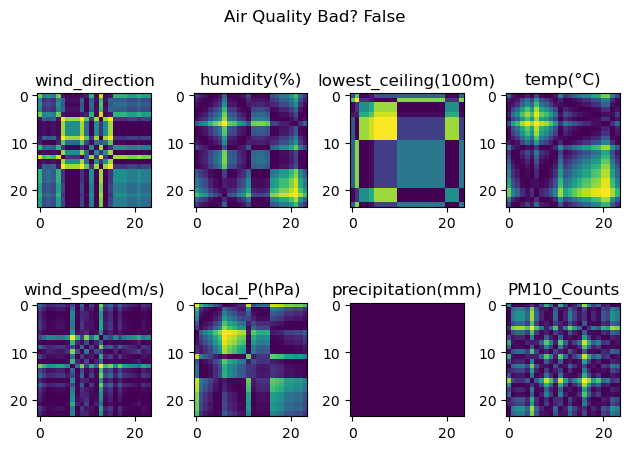

In [48]:
weather, label = next(iter(trainloader))
i = np.random.randint(0, 28)
fig, axs = plt.subplots(nrows=2, ncols=4)
r = 0
c = 0
for j in range(8):
    axs[r, c].imshow(weather[i, j, :, :])
    axs[r, c].set_title(f"{feature_names[j]}")
    if c < 3:
        c += 1
    else:
        r += 1
        c = 0
fig.suptitle(f"Air Quality Bad? {bool(label[i])}")
plt.tight_layout()
plt.show();

## 2.3. Preparation of CNN

In [49]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=(3, 3), padding=1),         # 16, 24x24 
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                        # 16, 12x12 
            nn.Dropout(0.2),
            nn.Conv2d(16, 8, kernel_size=(3, 3), padding=1),         # 8, 12x12 
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                        # 8,  6x6 
            nn.Dropout(0.2),
            nn.Conv2d(8, 4, kernel_size=(3, 3), padding=1),         # 4, 6x6 
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                        # 4, 3x3 
            nn.Dropout(0.2),
            nn.Flatten(),                                # 36
            nn.Linear(36, 9),                              # 9
            nn.ReLU(),
            nn.Linear(9, 1)
        )

    def forward(self, x):
        logits = self.main(x)
        return logits

In [50]:
model = ConvolutionalNeuralNetwork()

In [51]:
summary(model, (8, 24, 24), device="cpu");

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 16, 24, 24]          1,168
|    └─ReLU: 2-2                         [-1, 16, 24, 24]          --
|    └─MaxPool2d: 2-3                    [-1, 16, 12, 12]          --
|    └─Dropout: 2-4                      [-1, 16, 12, 12]          --
|    └─Conv2d: 2-5                       [-1, 8, 12, 12]           1,160
|    └─ReLU: 2-6                         [-1, 8, 12, 12]           --
|    └─MaxPool2d: 2-7                    [-1, 8, 6, 6]             --
|    └─Dropout: 2-8                      [-1, 8, 6, 6]             --
|    └─Conv2d: 2-9                       [-1, 4, 6, 6]             292
|    └─ReLU: 2-10                        [-1, 4, 6, 6]             --
|    └─MaxPool2d: 2-11                   [-1, 4, 3, 3]             --
|    └─Dropout: 2-12                     [-1, 4, 3, 3]             --
|    └─F

## 2.4. Model Training

In [52]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, patience=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_loss, valid_loss, train_accuracy, valid_accuracy = [], [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        train_batch_acc = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in trainloader:
            optimizer.zero_grad()       # Zero all the gradients w.r.t. parameters
            # X = X.to(device)
            # y = y.to(device)
            y_hat = model(X)  # forward pass to get output
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            loss = criterion(y_hat, y.unsqueeze(1))  # Calculate loss based on output
            loss.backward()             # Calculate gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()  # Add loss for this batch to running total
            train_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        train_loss.append(train_batch_loss / len(trainloader))
        train_accuracy.append(train_batch_acc / len(trainloader))  # accuracy
        
        # Validation
        model.eval()
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in validloader:
                # X = X.to(device)
                # y = y.to(device)
                y_hat = model(X)  # forward pass to get output
                y_hat_labels = torch.sigmoid(y_hat) > 0.5
                loss = criterion(y_hat, y.unsqueeze(1))
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))  # accuracy
        
        model.train()
        
        # Print progress
        if verbose:
            if (epoch+1) % 100 == 0:
                print(f"Epoch {epoch + 1}:",
                      f"Train Loss: {train_loss[-1]:.3f}.",
                      f"Valid Loss: {valid_loss[-1]:.3f}.",
                      f"Train Accuracy: {train_accuracy[-1]:.2f}."
                      f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
            
        # Early stopping
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(f"Stopped early at epoch {epoch + 1} - val loss increased for {consec_increases} consecutive epochs!")
            break
        
    print("\nTraining ended.")
    
    loss_fig = pd.DataFrame({"train_loss": train_loss, "valid_loss": valid_loss}).plot.line()
    loss_fig.set_xlabel('Epoch')
    loss_fig.set_ylabel('Loss');
    
    accur_fig = pd.DataFrame({"train_accuracy": train_accuracy, "valid_accuracy": valid_accuracy}).plot.line()
    accur_fig.set_xlabel('Epoch')
    accur_fig.set_ylabel('Accuracy');

In [53]:
model.apply(weights_init)

ConvolutionalNeuralNetwork(
  (main): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.2, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=36, out_features=9, bias=True)
    (14): ReLU()
    (15): Linear(in_features=9, out_features=1, bias=True)
  )
)

In [54]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

Epoch 100: Train Loss: 0.471. Valid Loss: 0.711. Train Accuracy: 0.78.Valid Accuracy: 0.61.
Epoch 200: Train Loss: 0.429. Valid Loss: 0.706. Train Accuracy: 0.79.Valid Accuracy: 0.63.
Epoch 300: Train Loss: 0.405. Valid Loss: 0.721. Train Accuracy: 0.81.Valid Accuracy: 0.62.
Epoch 400: Train Loss: 0.364. Valid Loss: 0.757. Train Accuracy: 0.84.Valid Accuracy: 0.62.
Epoch 500: Train Loss: 0.361. Valid Loss: 0.785. Train Accuracy: 0.84.Valid Accuracy: 0.63.
Epoch 600: Train Loss: 0.350. Valid Loss: 0.805. Train Accuracy: 0.84.Valid Accuracy: 0.61.
Epoch 700: Train Loss: 0.340. Valid Loss: 0.771. Train Accuracy: 0.84.Valid Accuracy: 0.63.
Epoch 800: Train Loss: 0.337. Valid Loss: 0.813. Train Accuracy: 0.85.Valid Accuracy: 0.63.
Epoch 900: Train Loss: 0.312. Valid Loss: 0.864. Train Accuracy: 0.87.Valid Accuracy: 0.60.
Epoch 1000: Train Loss: 0.336. Valid Loss: 0.840. Train Accuracy: 0.85.Valid Accuracy: 0.60.
Epoch 1100: Train Loss: 0.322. Valid Loss: 0.829. Train Accuracy: 0.86.Valid Ac

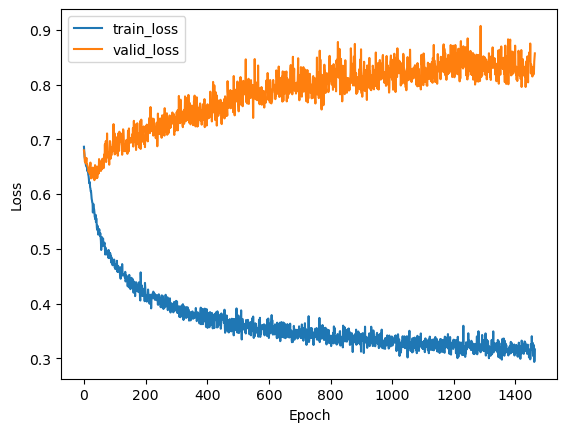

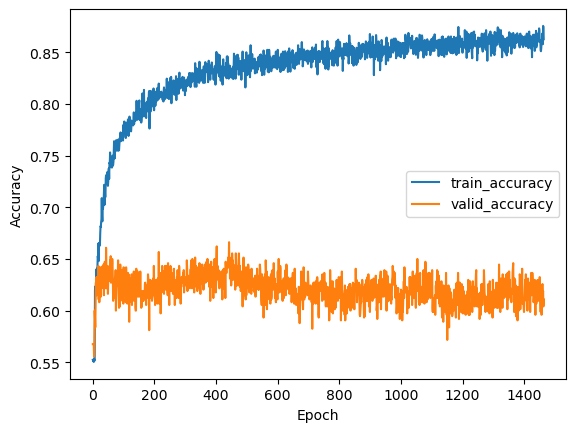

In [55]:
trainer(model, criterion, optimizer, trainloader, validloader, epochs=2001, patience=5, verbose=True)

## 2.5. Accuracy on Test Set

In [56]:
test_accuracy = []
test_batch_acc = 0

model.eval()
with torch.no_grad():
    for X, y in testloader:
        y_hat = model(X)  # forward pass to get output
        y_hat_labels = torch.sigmoid(y_hat) > 0.5
        test_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        
test_accuracy.append(test_batch_acc / len(testloader))  # accuracy

In [57]:
test_accuracy

[0.5337899610502262]

## 2.6. Prediction

Prbability of Bad Air Quality: 0.81


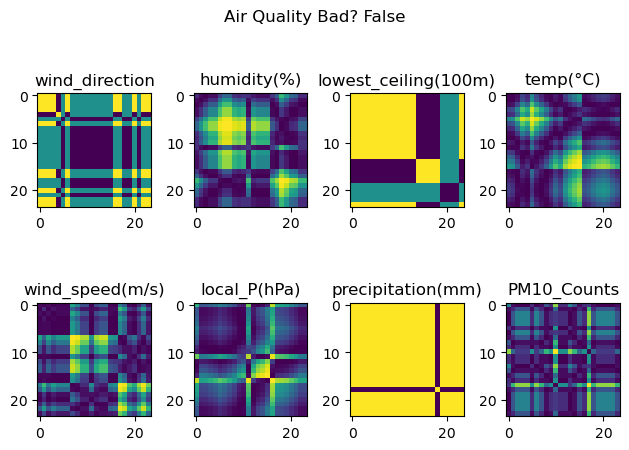

In [58]:
model.eval()
with torch.no_grad():
    wea, lab = next(iter(testloader))
    y_prob = torch.sigmoid(model(wea)[0])
    y_class = int(y_prob > 0.5)
    print(f"Prbability of Bad Air Quality: {y_prob.item():.3g}")
    fig, axs = plt.subplots(nrows=2, ncols=4)
    r = 0
    c = 0
    for j in range(8):
        axs[r, c].imshow(weather[0, j, :])
        axs[r, c].set_title(f"{feature_names[j]}")
        if c < 3:
            c += 1
        else:
            r += 1
            c = 0
    fig.suptitle(f"Air Quality Bad? {bool(lab[0])}")
    plt.tight_layout()
    plt.show();